In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from operator import attrgetter
import ROOT
import velo
from scatter import Scatter
from writer import prtStable, heavyFlavor, Writer, hitSel, Hits
from dataclasses import dataclass
from collections import namedtuple

Welcome to JupyROOT 6.18/04


In [3]:
tracks_info = pd.read_csv('tracks_info.txt', header = None, delimiter = "\t")
truth_track_info = pd.read_csv('truth_track_info.txt', header = None, delimiter = "\t")

In [4]:
trks = tracks_info.to_numpy()
truth_trks = truth_track_info.to_numpy()

In [5]:
@dataclass
class TrkInfo:
    lumi_section: int
    event_num: int
    trk_num: int
    pt: list
    cottheta: float
    phi: float
    d0: float
    z0: float
    cov: np.ndarray
        
@dataclass
class TruthTrkInfo:
    lumi_section: int
    event_num: int
    trk_num: int
    ptr: str
    charge: float
    px: float
    py: float
    pz: float
    vertexX: float
    vertexY: float
    vertexZ: float
    vid: int

In [6]:
track_list = []
for i in range(len(trks)):
    current = trks[i][0].split(maxsplit = 10)
    lum = int(current[1])
    evt = int(current[2])
    tnum = int(current[3])
    pt = [float(current[4]), float(current[5])]
    cottheta = float(current[6])
    phi = float(current[7])
    d0 = float(current[8])
    z0 = float(current[9])
    cov = np.array(literal_eval(current[10]))
    track = TrkInfo(lum, evt, tnum, pt, cottheta, phi, d0, z0, cov)
    track_list.append(track)

In [7]:
truth_track_list = []
for i in range(len(truth_trks)):
    current = truth_trks[i][0].split()
    if not len(current)==12:
        continue
    lum = int(current[1])
    evt = int(current[2])
    tnum = int(current[3])
    ptr = str(current[4])
    charge = int(current[5])
    px = float(current[6])
    py = float(current[7])
    pz = float(current[8])
    vertexX = float(current[9])
    vertexY = float(current[10])
    vertexZ = float(current[11])
    track = TruthTrkInfo(lum, evt, tnum, ptr, charge, px, py, pz, vertexX, vertexY, vertexZ, None)
    truth_track_list.append(track)

In [8]:
print(truth_track_list[0])

TruthTrkInfo(lumi_section=28, event_num=16988, trk_num=0, ptr='0x7f0e3600cd80', charge=-1, px=-2.31078, py=1.77023, pz=97.8958, vertexX=0.00302696, vertexY=0.00107761, vertexZ=-1.03371, vid=None)


In [9]:
@dataclass
class VertexInfo:
    lumi_section: int
    event_num: int
    vrtx_num: int
    x: float
    y: float
    z: float
    dx: float
    dy: float
    dz: float
    n_trks: int
    trk_pts: np.ndarray
        
@dataclass
class TruthVertexInfo:
    lumi_section: int
    event_num: int
    vrtx_num: int
    ptr: str
    x: float
    y: float
    z: float
    trk_ptr: list

In [10]:
vertex_info = pd.read_csv('vertex_info.txt', header = None, delimiter = "\t")
vrtx = vertex_info.to_numpy()
truth_vertex_info = pd.read_csv('truth_vertex_info.txt', header = None, delimiter = "\t")
truth_vrtx = truth_vertex_info.to_numpy()

In [11]:
vertex_list = []
for i in range(len(vrtx)):
    current = vrtx[i][0].split(maxsplit = 11)
    lum = int(current[1])
    evt = int(current[2])
    tnum = int(current[3])
    x = float(current[4])
    y = float(current[5])
    z = float(current[6])
    dx = float(current[7])
    dy = float(current[8])
    dz = float(current[9])
    num = int(current[10])
    pts = np.sort(np.fromstring(current[11], dtype=float, sep=' '))
    vertex = VertexInfo(lum, evt, tnum, x, y, z, dx, dy, dz, num, pts)
    vertex_list.append(vertex)

In [12]:
truth_vertex_list = []
for i in range(len(vrtx)):
    current = truth_vrtx[i][0].split(maxsplit = 8)
    lum = int(current[1])
    evt = int(current[2])
    tnum = int(current[3])
    ptr = str(current[4])
    x = float(current[5])
    y = float(current[6])
    z = float(current[7])
    trk_pointer = current[8].split()
    vertex = TruthVertexInfo(lum, evt, tnum, ptr, x, y, z, trk_pointer)
    truth_vertex_list.append(vertex)

In [13]:
# sort by event, then by pt for tracks
vertex_list = sorted(vertex_list, key = attrgetter('event_num') )
track_list = sorted(track_list, key = attrgetter('event_num'))
truth_vertex_list = sorted(truth_vertex_list, key = attrgetter('event_num') )
truth_track_list = sorted(truth_track_list, key = attrgetter('event_num'))

In [14]:
#grab first and last events
first = vertex_list[0].event_num
last = vertex_list[-1].event_num
print("Event Range: ", first, '-', last)


#create vertex dictionary, with keys corresponding to events
vertex_dict = {}
current_list = []
current_event = first
    
for i in range(len(vertex_list)):
    current_list.append(vertex_list[i])
    if i == len(vertex_list)-1 or vertex_list[i+1].event_num > current_event:
        vertex_dict[current_event] = current_list
        current_list = []
        current_event+=1
        
#create track dictionary, with keys corresponding to events
track_dict = {}
current_list = []
current_event = first
    
for i in range(len(track_list)):
    current_list.append(track_list[i])
    if i == len(track_list)-1 or track_list[i+1].event_num > current_event:
        track_dict[current_event] = current_list
        current_list = []
        current_event+=1
        
#create truth track dictionary, with keys corresponding to events
truth_track_dict = {}
current_list = []
current_event = first
    
for i in range(len(truth_track_list)):
    current_list.append(truth_track_list[i])
    if i == len(truth_track_list)-1 or truth_track_list[i+1].event_num > current_event:
        truth_track_dict[current_event] = current_list
        current_list = []
        current_event+=1
        
#create vertex track dictionary, with keys corresponding to events
truth_vertex_dict = {}
current_list = []
current_event = first
    
for i in range(len(truth_vertex_list)):
    current_list.append(truth_vertex_list[i])
    if i == len(truth_vertex_list)-1 or truth_vertex_list[i+1].event_num > current_event:
        truth_vertex_dict[current_event] = current_list
        current_list = []
        current_event+=1

Event Range:  16987 - 17188


In [15]:
# match tracks to vertices
matched = 0
for event in vertex_dict:
    if event in truth_vertex_dict.keys(): 
        for i in range(len(truth_vertex_dict[event])):
            if event in truth_track_dict.keys():
                for j in range(len(truth_track_dict[event])):
                    if truth_track_dict[event][j].ptr in truth_vertex_dict[event][i].trk_ptr:
                        truth_track_dict[event][j].vid = truth_vertex_dict[event][i].vrtx_num
                        matched+=1
    print(matched)

0
7383
7383
13550
13550
13550
22213
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
27557
2755

In [17]:
# Create the output TFile and TTree.
name = "/home/ekauffma/emk_test.root"
tfile = ROOT.TFile(name, "RECREATE")
ttree = ROOT.TTree("data", "")

with Writer(ttree) as writer:
    writer.add("pvr_x","pvr_y","pvr_z",
               "svr_x","svr_y","svr_z","svr_pvr", #TODO, currently do not have SVs
               "prt_pid","prt_px","prt_py","prt_pz","prt_e",
               "prt_x","prt_y","prt_z","prt_pvr","ntrks_prompt")

In [ ]:
for event in vertex_dict:
    vertices = {}
    for i in range(len(vertex_dict[event])):
        writer["pvr_x"].append(vertex_dict[event][i].x)
        writer["pvr_y"].append(vertex_dict[event][i].y)
        writer["pvr_z"].append(vertex_dict[event][i].z)
        writer["ntrks_prompt"].append(0) #TODO
        vertices[vertex_dict[event][i].vrtx_num] = i
    for i in range(len(truth_track_dict[event])):
        writer["prt_pid"].append(0) #TODO
        writer["prt_x"].append(truth_track_dict[event][i].vertexX)
        writer["prt_y"].append(truth_track_dict[event][i].vertexY)
        writer["prt_z"].append(truth_track_dict[event][i].vertexZ)
        writer["prt_px"].append(truth_track_dict[event][i].px)
        writer["prt_py"].append(truth_track_dict[event][i].py)
        writer["prt_pz"].append(truth_track_dict[event][i].pz)
        writer["prt_e"].append(0) #fill with zeros for now, probably won't use
        ## not sure if doing below correctly
        if truth_track_dict[event][i].vid in vertices.keys():
            writer["prt_pvr"].append(vertices[truth_track_dict[event][i].vid])
    for i in range(len(track_dict[event])):
        phi = track_dict[event][i].phi
        d = track_dict[event][i].d0
        ct = track_dict[event][i].cottheta
        
        #print('phi = ', phi)
        #print('arctan(py/px) = ', np.arctan(track_dict[event][i].pt[1]/track_dict[event][i].pt[0]))
        #y = (-2*d*np.cos(phi)+
             #np.sqrt(4*d**2*np.cos(phi)**2-4*(np.cos(phi)**2+np.sin(phi)**2)*
                     #(d**2-z**2*np.sin(phi)**2*(1/ct)**2)))/(2*(np.cos(phi)**2 + np.sin(phi)**2))
        #x = np.sqrt((z**2-y**2*ct**2)/(ct**2))
        writer["prt_px"].append(track_dict[event][i].pt[0])
        writer["prt_py"].append(track_dict[event][i].pt[1])
        writer["prt_pz"].append(0)
        writer["prt_e"].append(0)
    ttree.Fill()
    writer.clear()
ttree.Print()
ttree.Write(ttree.GetName(), ROOT.TObject.kOverwrite)
tfile.Close()

In [ ]:
import uproot
testfile = uproot.open("emk_test.root")

In [16]:
data = testfile["data"]

In [17]:
data.show()

pvr_x                      TStreamerSTL               asjagged(asdtype('>f8'), 10)
pvr_y                      TStreamerSTL               asjagged(asdtype('>f8'), 10)
pvr_z                      TStreamerSTL               asjagged(asdtype('>f8'), 10)
prt_px                     TStreamerSTL               asjagged(asdtype('>f8'), 10)
prt_py                     TStreamerSTL               asjagged(asdtype('>f8'), 10)
prt_pz                     TStreamerSTL               asjagged(asdtype('>f8'), 10)
prt_e                      TStreamerSTL               asjagged(asdtype('>f8'), 10)
prt_x                      TStreamerSTL               asjagged(asdtype('>f8'), 10)
prt_y                      TStreamerSTL               asjagged(asdtype('>f8'), 10)
prt_z                      TStreamerSTL               asjagged(asdtype('>f8'), 10)


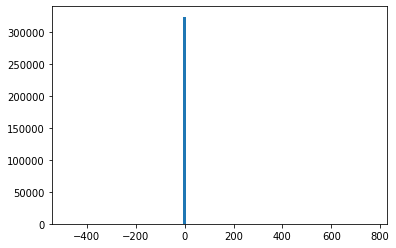

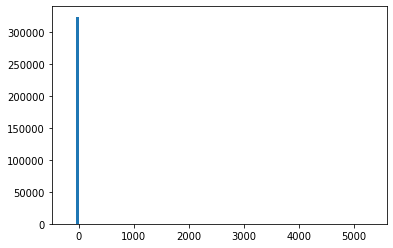

In [18]:
prt_x = data["prt_x"].array()
plt.hist(prt_x.flatten(),bins=100)
plt.show()

prt_y = data["prt_y"].array()
plt.hist(prt_y.flatten(),bins=100)
plt.show()